# Projet 5: notebook de tests

Ce notebook se compose de trois parties.

La première partie présente la mise en oeuvre d'une approche non supervisée afin de proposer des tags.

La deuxième partie présente les tests de différents algorithmes de classification supervisée sur des données en bag of words.

La troisième partie se compose également de tests de classification supervisée, mais cette fois-ci sur les données textuelles après avoir effectuée un word embedding.

Ce notebook a été exécuté en deux fois à l'aide de 2 environnements différents car il semble y avoir un problème de compatibilité entre la fonction Ldamulticore de gensim et un autre package.

In [1]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importation des données

In [2]:
data = pd.read_csv("data.csv")
data

,Title,Body,Tags,title_bow_lem,body_bow_lem,title_bow_stem,body_bow_stem
0,spring mvc angularjs file upload org apa...,i have a java spring mvc web application as se...,"['spring', 'mvc', 'file', 'java']","['spring', 'mvc', 'angularjs', 'file', 'org', ...","['java', 'spring', 'mvc', 'application', 'serv...","['spring', 'mvc', 'angularj', 'file', 'org', '...","['java', 'spring', 'mvc', 'applic', 'server', ..."
1,what are some examples of design pattern imple...,i m a moderately skilled programmer using java...,"['design', 'javascript']","['design', 'javascript']","['programmer', 'javascript', 'guru', 'dom', 'm...","['design', 'javascript']","['programm', 'javascript', 'guru', 'dom', 'man..."
2,what s the best way to get to know linux or bs...,i d like to gain better knowledge of operating...,['linux'],"['linux', 'bsd']","['knowledge', 'operating', 'system', 'manageme...","['linux', 'bsd']","['knowledg', 'oper', 'system', 'manag', 'memor..."
3,is there a performance difference between i ...,is there a performance difference between and...,"['c', 'performance']","['performance', 'difference', 'c']","['performance', 'difference', 'value']","['perform', 'differ', 'c']","['perform', 'differ', 'valu']"
4,is there a performance difference between i ...,we have the question is there a performance di...,"['cplusplus', 'performance']","['performance', 'difference', 'cplusplus']","['performance', 'difference', 'c', 'answer', '...","['perform', 'differ', 'cplusplus']","['perform', 'differ', 'c', 'answer', 'cplusplus']"
...,...,...,...,...,...,...,...
24075,how does keras 1d convolution layer work with ...,i am currently developing a text classificatio...,['python'],"['convolution', 'layer', 'work', 'word', 'clas...","['text', 'classification', 'tool', 'validation...","['convolut', 'layer', 'work', 'word', 'classif...","['text', 'classif', 'tool', 'valid', 'accuraci..."
24076,clean architecture design pattern,i have some question about this pattern the...,"['design', 'java']","['architecture', 'design', 'pattern']","['pattern', 'database', 'layer', 'work', 'real...","['architectur', 'design', 'pattern']","['pattern', 'databas', 'layer', 'work', 'reali..."
24077,how to do nd distance and nearest neighbor cal...,this question is intended to be a canonical du...,"['python', 'arrays']","['distance', 'neighbor']","['duplicate', 'target', 'distance', 'shape', '...","['distanc', 'neighbor']","['duplic', 'target', 'distanc', 'shape', 'poin..."
24078,android studio emulator is not working on wind...,i have windows 11 on my system the system spe...,"['studio', 'windows', 'android']","['studio', 'emulator', 'whpx']","['system', 'system', 'specifiction', 'edition'...","['studio', 'emul', 'whpx']","['system', 'system', 'specifict', 'edit', 'hom..."


In [3]:
# Actuellement, ce que nous voyons entre crochets dans le tableau ne sont pas des listes mais des chaînes de caractères
# On les transforme en listes
for c in ['Tags', 'title_bow_lem', 'body_bow_lem', 'title_bow_stem', 'body_bow_stem']:
    data[c] = data[c].apply(lambda x: eval(x))

# Approche non supervisé: LDA

On va effectuer des classifications non supervisées à partir des différentes variables en bag of words et pour différents nombres de 'topics'. On comparera ces différentes classifications à l'aide du score de cohérence pour déterminer le meilleur choix. 

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test = train_test_split(data, train_size=0.8, random_state=27)

La séparation des données en jeu d'entraînement et jeu de test mérite quelques explications. En effet la LDA est une méthode non supervisée qui ne va pas nous donner exactement 3 tags pour une question, 5 pour une autre etc... Mais on pourrait tenter une approche "semi-supervisée" en combinant les tags des questions d'un jeu d'entraînement et la "proximité" des questions du jeu de test aux différentes questions du jeu d'entraînement. Ce ne sera pas fait dans ce notebook mais on va conserver quand même un peu de cette démarche, notamment en construisant des matrices de probabilités à la fin de cette partie.

In [6]:
# Préprocessing des données pour LDA
def create_corpus(texts): 
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    return corpus, id2word

# Classification en k topics et calcul du score de cohérence
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = LdaMulticore(corpus=corpus,
                               id2word=dictionary,
                               num_topics=k, 
                               random_state=100,
                               chunksize=100,
                               passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

# Test de différents nombres de topics pour un même jeu de données
def test_multiple_topics(corpus, id2word):
    model_results = {'Topics': [],'Coherence': []}
    pbar = tqdm.tqdm(total=len(topics_range))

    for k in topics_range:
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)

        pbar.update(1)
    resultats = pd.DataFrame(model_results)
    pbar.close()
    return resultats

In [7]:
# Les différents nombres de topics testés
min_topics = 15
max_topics = 50
step_size = 5
topics_range = range(min_topics, max_topics, step_size)

In [8]:
# Pour comparer les résultats suivant les différents jeu de données
compar_resultats = {}

## body_bow_lem

In [9]:
texts = X_train['body_bow_lem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [10]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:31<00:00, 38.76s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

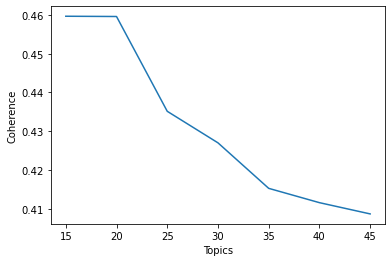

In [11]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [12]:
best_coherence_data_lem_body = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Coherence')
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

15

In [13]:
compar_resultats['body_bow_lem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [14]:
lda_model_lem_body = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [15]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lem_body, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.198405  0.196464       1        1  10.012881
13    -0.001650  0.278823       2        1   8.249700
2     -0.076568  0.128364       3        1   8.067894
0      0.026001  0.053000       4        1   7.690319
3      0.148197  0.082975       5        1   7.615683
8     -0.306773 -0.021513       6        1   7.460789
12     0.048141 -0.055995       7        1   6.913605
11     0.126293  0.204366       8        1   6.809191
4     -0.090350 -0.096720       9        1   6.775393
9     -0.148529  0.008929      10        1   6.505526
5      0.284462  0.023604      11        1   5.551788
7      0.249730 -0.148405      12        1   5.008811
10    -0.179195 -0.178614      13        1   4.944323
6      0.134415 -0.221429      14        1   4.676667
1     -0.015769 -0.253847      15        1   3.717431, topic_info=           Term         Freq        Total Category  logprob  loglift
185       image  2432.000000  2432.000000  Default  30.0000  30.0000
56   javascript  2415.000000  2415.000000  Default  29.0000  29.0000
704        view  2112.000000  2112.000000  Default  28.0000  28.0000
48         file  5535.000000  5535.000000  Default  27.0000  27.0000
265       array  1434.000000  1434.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
2      function   123.030295  2724.391557  Topic15  -4.8402   0.1946
300       value    91.295689  1947.282972  Topic15  -5.1385   0.2321
48         file   100.353416  5535.628831  Topic15  -5.0439  -0.7181
219      object    83.669728  1754.273681  Topic15  -5.2258   0.2492
253      option    76.739545   843.366797  Topic15  -5.3122   0.8952

[1156 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3355      8  0.971885            aar
1635      5  0.058276   acceleration
1635     15  0.903272   acceleration
2609      1  0.018981  accelerometer
2609      7  0.018981  accelerometer
...     ...       ...            ...
1143      6  0.017797            zip
1143      8  0.008898            zip
1143     11  0.934321            zip
1143     13  0.017797            zip
6486      7  0.982139           zone

[5658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 3, 1, 4, 9, 13, 12, 5, 10, 6, 8, 11, 7, 2])

On refait ensuite la même chose avec d'autres variables.

## title_bow_lem

In [16]:
texts = X_train['title_bow_lem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [17]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:45<00:00, 23.58s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

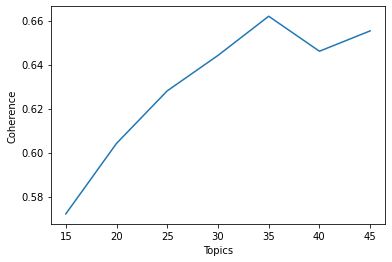

In [18]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [19]:
best_coherence_title_lem_body = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Coherence')
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

35

In [20]:
compar_resultats['title_bow_lem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [21]:
lda_model_lem_title = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [22]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lem_title, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27     0.454429 -0.136088       1        1  3.816111
16     0.195687 -0.303888       2        1  3.752787
4     -0.449833  0.155602       3        1  3.713244
7     -0.308713 -0.343991       4        1  3.602389
24     0.060761  0.463161       5        1  3.453074
15     0.225017  0.415208       6        1  3.388927
0     -0.303969  0.340548       7        1  3.165274
29    -0.189289  0.394272       8        1  3.161357
17     0.167966 -0.405634       9        1  3.151592
3      0.450927  0.096829      10        1  3.128496
8     -0.371709 -0.237026      11        1  3.122334
25     0.038990 -0.455210      12        1  3.051886
1     -0.436734 -0.122784      13        1  3.018849
18    -0.144410 -0.210321      14        1  3.008967
20    -0.267258  0.057233      15        1  2.979969
22     0.357318 -0.211742      16        1  2.941723
11    -0.091561 -0.424111      17        1  2.918687
33     0.256844 -0.056676      18        1  2.878157
14     0.014862 -0.290927      19        1  2.861066
6     -0.426410  0.026678      20        1  2.785015
34    -0.068578  0.427699      21        1  2.741564
12     0.383488  0.176416      22        1  2.715558
28     0.300960 -0.315915      23        1  2.699503
23     0.067001 -0.092815      24        1  2.575079
2      0.379938 -0.010574      25        1  2.533828
32    -0.186851 -0.363557      26        1  2.529230
26    -0.322444  0.215151      27        1  2.454772
10     0.147088  0.086304      28        1  2.431785
5     -0.079066  0.001108      29        1  2.380080
19    -0.275333 -0.087822      30        1  2.328016
21     0.202645  0.279924      31        1  2.207634
9     -0.036485  0.272003      32        1  2.168260
30    -0.131848  0.176486      33        1  2.143979
13     0.309599  0.253159      34        1  2.126668
31     0.076971  0.231298      35        1  2.064139, topic_info=            Term        Freq       Total Category  logprob  loglift
8     javascript  718.000000  718.000000  Default  30.0000  30.0000
28        python  750.000000  750.000000  Default  29.0000  29.0000
85          file  647.000000  647.000000  Default  28.0000  28.0000
234            v  562.000000  562.000000  Default  27.0000  27.0000
157   difference  463.000000  463.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2490    exchange    6.955686    7.965533  Topic35  -5.2003   3.7449
1922          v3    6.463239    7.477909  Topic35  -5.2738   3.7346
974      sandbox    5.764555    6.774402  Topic35  -5.3882   3.7190
257          api   52.111898  232.999333  Topic35  -3.1865   2.3828
960          bug    7.834064   13.750531  Topic35  -5.0814   3.3179

[1207 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1237     25  0.840212            aar
934      19  0.922442  accelerometer
126       6  0.152719         access
126      32  0.827522         access
126      33  0.010655         access
...     ...       ...            ...
1470     26  0.958772        youtube
1167     23  0.941832              z
1948     31  0.866825           zend
1333     16  0.972367            zip
108      23  0.965141           zoom

[1430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 17, 5, 8, 25, 16, 1, 30, 18, 4, 9, 26, 2, 19, 21, 23, 12, 34, 15, 7, 35, 13, 29, 24, 3, 33, 27, 11, 6, 20, 22, 10, 31, 14, 32])

## body_bow_stem

In [23]:
texts = X_train['body_bow_stem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [24]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:14<00:00, 36.31s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

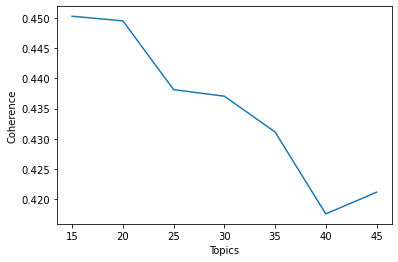

In [25]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [26]:
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

15

In [27]:
compar_resultats['body_bow_stem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [28]:
lda_model_stem_body = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [29]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_stem_body, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.240354  0.131964       1        1  11.714971
4      0.025816  0.265359       2        1   9.853295
0     -0.180539  0.027636       3        1   9.781484
6      0.039738  0.154434       4        1   7.781485
11     0.216974  0.063487       5        1   6.851550
8     -0.100659  0.221148       6        1   6.662338
3      0.101813 -0.301213       7        1   6.594255
14     0.161805  0.206490       8        1   6.251623
9     -0.166166 -0.158012       9        1   5.385252
12    -0.038594 -0.088111      10        1   5.354029
1      0.039894 -0.062613      11        1   5.210671
13     0.141744 -0.034250      12        1   5.199143
7     -0.242782 -0.045936      13        1   4.983557
5      0.273458 -0.149788      14        1   4.888376
2     -0.032147 -0.230595      15        1   3.487970, topic_info=         Term         Freq        Total Category  logprob  loglift
183      imag  2466.000000  2466.000000  Default  30.0000  30.0000
686      view  1923.000000  1923.000000  Default  29.0000  29.0000
321      page  2315.000000  2315.000000  Default  28.0000  28.0000
169       app  3713.000000  3713.000000  Default  27.0000  27.0000
6     project  2785.000000  2785.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
77     someon    69.429233  1010.610475  Topic15  -5.3485   0.6778
170       bit    70.026838  1322.369978  Topic15  -5.3399   0.4175
2    function    73.070840  3285.052342  Topic15  -5.2974  -0.4499
82       time    72.006762  3720.062946  Topic15  -5.3121  -0.5889
437     sourc    67.605305  1136.976951  Topic15  -5.3751   0.5334

[1157 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3149     15  0.978654          aar
2465      6  0.040245  acceleromet
2465      9  0.925645  acceleromet
297       1  0.461090       access
297       2  0.061634       access
...     ...       ...          ...
1049     11  0.011770       youtub
7182      2  0.922781         zlib
1477     13  0.954874        zombi
5988      4  0.192567         zone
5988      6  0.785079         zone

[5567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 1, 7, 12, 9, 4, 15, 10, 13, 2, 14, 8, 6, 3])

## title_bow_stem

In [30]:
texts = X_train['title_bow_stem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [31]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:41<00:00, 23.03s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

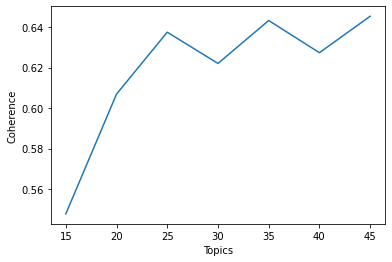

In [32]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [33]:
best_coherence_title_lem_body = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Coherence')
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

45

In [34]:
compar_resultats['title_bow_stem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [35]:
lda_model_stem_title = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [36]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_stem_title, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
35     0.335778  0.339753       1        1  3.323594
9     -0.042224  0.473524       2        1  3.318896
30    -0.271340  0.379898       3        1  3.187130
22     0.464828  0.130730       4        1  2.993309
24     0.088591  0.431657       5        1  2.965528
38    -0.172956  0.393146       6        1  2.917829
41     0.052472 -0.445127       7        1  2.709422
32    -0.239783 -0.376344       8        1  2.701572
10     0.468002 -0.005649       9        1  2.698767
12    -0.039380  0.369022      10        1  2.657662
0     -0.104378 -0.362582      11        1  2.610758
11     0.407386 -0.100656      12        1  2.540925
37     0.145579 -0.430356      13        1  2.514267
16    -0.402478  0.239571      14        1  2.506623
33     0.183797  0.380352      15        1  2.395468
40     0.357659  0.218958      16        1  2.360648
13    -0.114037 -0.448072      17        1  2.280486
21    -0.005599 -0.174967      18        1  2.221594
39    -0.344171 -0.310545      19        1  2.198109
3      0.257336 -0.367788      20        1  2.182318
4      0.373736 -0.243915      21        1  2.154471
7     -0.356915 -0.138839      22        1  2.151428
29     0.329412 -0.093755      23        1  2.118553
2     -0.197914  0.195013      24        1  2.115017
31     0.281127  0.038501      25        1  2.097422
5     -0.323731 -0.218032      26        1  2.092653
19    -0.447766 -0.065672      27        1  2.074475
36    -0.321911  0.122896      28        1  2.066736
14     0.270923  0.159371      29        1  2.011966
43    -0.243473 -0.005573      30        1  2.004603
42    -0.263362  0.258780      31        1  2.004023
8     -0.421257  0.094663      32        1  2.002452
17     0.191631  0.284125      33        1  1.994344
26    -0.367256 -0.027038      34        1  1.968462
27     0.220160 -0.132450      35        1  1.961607
25    -0.181431 -0.218902      36        1  1.820245
20    -0.005069 -0.300374      37        1  1.733003
28     0.270983 -0.258143      38        1  1.697506
44     0.103474 -0.026164      39        1  1.622064
6      0.037257  0.242105      40        1  1.594825
1      0.135044 -0.268393      41        1  1.571974
34    -0.048447  0.038883      42        1  1.568360
23     0.096547  0.137458      43        1  1.556105
18    -0.087821 -0.058937      44        1  1.419625
15    -0.069020  0.149867      45        1  1.313176, topic_info=         Term        Freq       Total Category  logprob  loglift
85       file  658.000000  658.000000  Default  30.0000  30.0000
233        vs  535.000000  535.000000  Default  29.0000  29.0000
86     spring  424.000000  424.000000  Default  28.0000  28.0000
338      time  355.000000  355.000000  Default  27.0000  27.0000
157    differ  454.000000  454.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2588  taskbar    3.652744    4.650816  Topic45  -5.3921   4.0912
735   outlook    6.086376    8.368744  Topic45  -4.8816   4.0143
1061   indent    4.821971    7.550259  Topic45  -5.1144   3.8843
28     python   16.600297  789.969780  Topic45  -3.8782   0.4701
536       bit    5.936949   74.497274  Topic45  -4.9064   1.8032

[1701 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1190     23  0.906933          aar
2282     16  0.785329          abi
491      33  0.778871      acceler
904       9  0.920402  acceleromet
126       2  0.720491       access
...     ...       ...          ...
1857     42  0.793753         zend
1280     40  0.920553          zip
2685     16  0.969766         zone
108      10  0.791316         zoom
108      16  0.098915         zoom

[2972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[36, 10, 31, 23, 25, 39, 42, 33, 11, 13, 1, 12, 38, 17, 34, 41, 14, 22, 40, 4, 5, 8, 30, 

## Bilan de la LDA

In [37]:
pd.DataFrame(compar_resultats, index=['n_topics', 'coherence_score'])

,body_bow_lem,title_bow_lem,body_bow_stem,title_bow_stem
n_topics,15.000000,35.000000,15.00000,45.000000
coherence_score,0.459667,0.661983,0.45027,0.645412


Il y a peu d'écart entre la lemmatisation et la stemmatisation. En revanche le fait de ne prendre en compte que les titres donne clairement de meilleurs résultats.

In [38]:
texts = X_train['title_bow_lem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [39]:
# Matrice de la probabilité des mots pour chaque topic
M_topics_words = pd.DataFrame(
    lda_model_lem_title.get_topics(), 
    columns=lda_model_lem_title.id2word.values(), 
    index=[f'topic {i}' for i in range(lda_model_lem_title.num_topics)])

In [40]:
M_topics_words

,asm,name,q0,register,locationlistener,network_provider,ssl,change,javascript,orientation,...,actionfilter,areaname,controllername,pyvenv,venv,print_r,fileinputstream,prophet,inject,diameter
topic 0,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000558,0.000014,...,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014
topic 1,0.000015,0.065893,0.000015,0.000015,0.000015,0.000015,0.000018,0.000223,0.385869,0.000162,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
topic 2,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000034,0.000018,...,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
topic 3,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000021,0.000016,...,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016
topic 4,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000021,0.000013,...,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013
topic 5,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
topic 6,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000065,0.000018,...,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
topic 7,0.000012,0.000014,0.000012,0.000012,0.000012,0.000012,0.000012,0.000083,0.000089,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
topic 8,0.000015,0.000015,0.000015,0.000023,0.000015,0.000015,0.000015,0.000015,0.000046,0.000015,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
topic 9,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000073,0.000025,...,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025


In [41]:
# Matrice de la probabilité pour une question d'appartenir à chacun des topics
a = len(lda_model_lem_title.get_document_topics(corpus[0], minimum_probability=0))
M_quest_topics = {i:[lda_model_lem_title.get_document_topics(corpus[i], minimum_probability=0)[j][1] for j in range(a)] for i in range(len(corpus))}
M_quest_topics = pd.DataFrame.from_dict(M_quest_topics, orient='index')
M_quest_topics

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.005716,0.205771,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,...,0.005716,0.005716,0.605603,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716
1,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
2,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,...,0.014286,0.014286,0.514282,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286
3,0.007143,0.257665,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.256892
4,0.004082,0.146941,0.004082,0.004082,0.004082,0.004082,0.146935,0.004082,0.004082,0.004082,...,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.432654,0.004082,0.004082,0.004082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19259,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,...,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082
19260,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143
19261,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.146939,0.004082,0.004082,...,0.004082,0.004082,0.004082,0.004082,0.575473,0.004082,0.146975,0.004082,0.004082,0.004082
19262,0.007143,0.257143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.507140,0.007143,0.007143,0.007143


In [42]:
# Probabilité des mots pour chaque question
M_quest_words = np.dot(M_quest_topics.to_numpy(), M_topics_words.to_numpy())
M_quest_words

array([[1.2951595e-03, 1.3590533e-02, 2.4141713e-04, ..., 1.4553716e-05,
        1.4553716e-05, 1.4553716e-05],
       [7.8035409e-05, 1.9238110e-03, 2.8321412e-05, ..., 1.7618335e-05,
        1.7618335e-05, 1.7618335e-05],
       [1.1029341e-03, 9.8141038e-04, 2.0808860e-04, ..., 1.5434565e-05,
        1.5434565e-05, 1.5434565e-05],
       ...,
       [2.5071078e-05, 3.0054883e-04, 1.7969014e-05, ..., 1.6439988e-05,
        1.6439988e-05, 1.6439988e-05],
       [3.5876721e-05, 1.6966799e-02, 2.3448081e-05, ..., 2.0772282e-05,
        2.0772282e-05, 2.0772282e-05],
       [3.3666478e-05, 4.9511757e-04, 2.1237780e-05, ..., 1.8561968e-05,
        1.8561968e-05, 1.8561968e-05]], dtype=float32)

# Appoche supervisée: bag of words

On commence par mettre les classes, c'est-à-dire la colonne 'Tags', sous un format approprié.

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(data['Tags'])
y = pd.DataFrame(y, columns=multilabel.classes_)
y

,algorithm,android,api,arrays,aspdotnet,c,cocoa,core,cplusplus,csharp,...,sql,string,studio,swift,testing,touch,visual,web,windows,xcode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24077,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24078,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


On peut effectuer énormément de tests différents. En effet, on dispose de 4 variables différentes pour effectuer des tests ('title_bow_lem', 'body_bow_lem', 'title_bow_stem' et 'body_bow_stem') et de toutes une panoplie d'algorithmes de classification supervisé, lesquels fonctionnant avec des hyperparamètres que l'on peut modifier. Tout cela fait beaucoup trop de possibilités.

Mais on peut raisonnablement penser que le passage d'une version des données lemmatisées à son homologue stemmatisées ne va pas modifier considérablement les performances d'un algorithme. De plus on aimerai bien qu'il n'y ai pas un trop gros écart de performance entre un entrainement sur les titres et un entraînement sur le corps des questions puisque cela signifierait que l'algorithme est très sensible à la longueur des questions, ce que l'on ne controle pas.

On va donc effectuer un premier tri des algorithmes à l'aide d'un seul jeu de données: 'body_bow_lem'. De plus les temps de calcul risquent d'être assez long donc on fera des validations croisées seulement après avoir éliminé les algorithmes inefficaces.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = data['body_bow_lem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Les différents algorithme que nous allons tester
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Il s'agit d'une classification multilabel
from sklearn.multiclass import OneVsRestClassifier

# Pour mesurer la qualité des prédictions
from sklearn.metrics import jaccard_score

# Pour la validation croisée
from sklearn.model_selection import GridSearchCV

# Pour mesurer les temps de calcul
import timeit

In [9]:
resultats = {}

In [10]:
def test_model(model, X, Y):
    pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(model)),
            ])
    start_time = timeit.default_timer()
    pipeline.fit(X, Y)
    temps = timeit.default_timer() - start_time
    print("Temps d'entrainement: {}".format(temps))
    return pipeline

## Multinomial

In [11]:
NB_pipeline = test_model(MultinomialNB(), X_train, Y_train)

Temps d'entrainement: 0.31065239999998084


In [12]:
pred = NB_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.005533816498293145

Le modèle est rapide à entrainer, mais le résultat est catastrophique.

## Linear SVC

In [13]:
SVC_pipeline = test_model(LinearSVC(), X_train, Y_train)

Temps d'entrainement: 1.0432349999999815


In [14]:
pred = SVC_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.31384321218641675

Ce n'est pas bon, mais on a au moins un résultat non nul. Le temps d'entraînement est très correct. On peut oublier le modèle précédent et on va même le supprimer pour faire de la place en mémoire car BERT sera très gourmand en espace mémoire.

In [15]:
del NB_pipeline

In [16]:
resultats['SVC_body_lem'] = jaccard_score(Y_test, pred, average='macro')

## Forêts aléatoires

L'entrainement de ce modèle est extrêmement long, même avec un hyperparamètre n_estimators assez faible et sans validation croisée, donc on ne l'utilisera pas.

In [17]:
RFC_pipeline = test_model(RandomForestClassifier(n_estimators=50), X_train, Y_train)

Temps d'entrainement: 86.7301084


In [18]:
pred = RFC_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.16898390660034046

In [19]:
del RFC_pipeline

## AdaBoost

In [20]:
ADB_pipeline = test_model(AdaBoostClassifier(n_estimators=100, learning_rate=1), X_train, Y_train)

Temps d'entrainement: 89.98154879999998


In [21]:
pred = ADB_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.2958769557534337

La prédiction est de même qualité que pour le SVC linéaire, mais le temps d'entraînement est problématique. Finalement, on choisira un modèle SVC linéaire comme modèle de référence.

In [22]:
del ADB_pipeline

## Etude approfondie du SVC linéaire

### title_bow_lem

In [23]:
X = data['title_bow_lem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [24]:
# grille d'hyperparamètres
param_grid = {'C': [0.5, 1, 2, 5]}

# Validation croisée
grid_pred = GridSearchCV(
        LinearSVC(),
        param_grid,
        cv=5)

In [25]:
pipeline = test_model(grid_pred, X_train, Y_train)

Temps d'entrainement: 14.412974200000008


In [26]:
pred = pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.3074873000500524

In [27]:
resultats['SVC_title_lem'] = jaccard_score(Y_test, pred, average='macro')

### body_bow_stem

In [28]:
X = data['body_bow_stem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [29]:
pipeline = test_model(grid_pred, X_train, Y_train)

Temps d'entrainement: 19.64190940000003


In [30]:
pred = pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.30788882312110144

In [31]:
resultats['SVC_body_stem'] = jaccard_score(Y_test, pred, average='macro')

### title_bow_stem

In [32]:
X = data['title_bow_stem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [33]:
pipeline = test_model(grid_pred, X_train, Y_train)

Temps d'entrainement: 14.57788579999999


In [34]:
pred = pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.3082722516588442

In [35]:
resultats['SVC_title_stem'] = jaccard_score(Y_test, pred, average='macro')

In [36]:
resultats

{'SVC_body_lem': 0.31384321218641675,
 'SVC_title_lem': 0.3074873000500524,
 'SVC_body_stem': 0.30788882312110144,
 'SVC_title_stem': 0.3082722516588442}

Tous ces résultats sont très proche l'un de l'autre. Notre performance de référence sera donc de 0.31. Avant de passer au word embedding une question s'impose.

## Et sans machine learning?

Au vu des mauvais résultats que nous avons eu jusqu'à maintenant on peut se demander s'il ne sera pas plus efficace de simplement tester la présence ou non d'un tags dans le corps d'une question pour la classer. Ce n'est pas du machine learning, mais c'est très simple à mettre en oeuvre.

In [37]:
def direct_clf(text, labels):
    tags = [m for m in labels if(m in text)]
    return tags

In [39]:
labels = multilabel.classes_.tolist()
pred = data['Body'].apply(lambda x: direct_clf(x, labels))
pred = multilabel.transform(pred)

In [40]:
jaccard_score(y, pred, average='macro')

0.2933100821788555

Le résultat est très proche du linear SVC.

In [41]:
resultats['Sans machine learning'] = jaccard_score(y, pred, average='macro')

# Appoche supervisée:  Word embedding

Nous testerons successivement Word2Vec, BERT puis USE.

## Word2Vec

In [42]:
import gensim

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

### body_bow_lem

In [43]:
X = data['body_bow_lem'].apply(lambda x: ' '.join(x))

In [44]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 739 

In [45]:
sentences = X.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [46]:
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=4)

In [47]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 20472
Word2Vec trained


In [48]:
# Préparation des phrases

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 20473


In [49]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (20473, 300)


In [50]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 739)]             0         
                                                                 
 embedding (Embedding)       (None, 739, 300)          6141900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 6,141,900
Trainable params: 6,141,900
Non-trainable params: 0
_________________________________________________________________


In [51]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

753/753 [==============================] - 6s 5ms/step


(24080, 300)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, y, random_state=21, train_size=0.8)

In [53]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.10944055942948287

C'est clairement moins bien que l'approche en bag of words.

In [54]:
resultats['Word2Vec_body_lem'] = jaccard_score(Y_test, pred, average='macro')

### title_bow_lem

In [55]:
X = data['title_bow_lem'].apply(lambda x: ' '.join(x))

In [56]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 16 

In [57]:
sentences = X.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [58]:
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=4)

In [59]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 6994
Word2Vec trained


In [60]:
# Préparation des phrases

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 6995


In [61]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (6995, 300)


In [62]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 16, 300)           2098500   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 2,098,500
Trainable params: 2,098,500
Non-trainable params: 0
_________________________________________________________________


In [63]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

753/753 [==============================] - 0s 547us/step


(24080, 300)

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, y, random_state=21, train_size=0.8)

In [65]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.2522582807222007

In [66]:
resultats['Word2Vec_title_lem'] = jaccard_score(Y_test, pred, average='macro')

On obtient un bien meilleur résultat avec les titres, mais ça reste quand même mauvais. On ne va pas essayer les données stemmatisées.

# BERT

In [67]:
import time
import transformers

In [68]:
# Fonction de préparation des phrases
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [69]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Cette approche est très gourmande en mémoire et nous devons donc diminuer drastiquement la taille de notre jeu de données.

In [70]:
X = data.iloc[:2000]

In [71]:
sentences = X['Body'].to_list()

In [72]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 331ms/step


1/1 [==============================] - 0s 314ms/step
temps traitement :  84.0


In [73]:
features_bert.shape

(2000, 768)

In [74]:
features_bert

array([[-0.33905655,  0.05436851,  0.47787276, ..., -0.2084786 ,
        -0.07084918,  0.11342107],
       [ 0.06121304,  0.3294199 ,  0.06483375, ..., -0.49412897,
        -0.12590241,  0.21730705],
       [ 0.03342314,  0.05691605,  0.07889195, ..., -0.20822984,
         0.11030117,  0.16039854],
       ...,
       [-0.3465042 ,  0.0840719 ,  0.16329908, ..., -0.3389861 ,
        -0.16352265,  0.3007849 ],
       [ 0.17491354,  0.1763647 ,  0.18499339, ..., -0.27794898,
         0.24425152,  0.13305566],
       [-0.2680949 ,  0.02302255,  0.2208793 , ..., -0.36063537,
         0.16676304,  0.20539857]], dtype=float32)

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(features_bert, y[:2000], random_state=21, train_size=0.8)

In [76]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.15254410497417323

C'est un peu mieux que Word2Vec, mais toujours très en-dessous de notre modèle de référence.

In [77]:
resultats['Bert'] = jaccard_score(Y_test, pred, average='macro')

## Sur les titres

In [78]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [79]:
sentences = data['Title'].iloc[:3000].to_list()

In [80]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 348ms/step
temps traitement :  131.0


In [81]:
features_bert.shape

(3000, 768)

In [82]:
features_bert

array([[-0.03973114, -0.16730933,  0.4403028 , ..., -0.08380175,
        -0.15140991, -0.1375908 ],
       [ 0.14973862, -0.08388011, -0.06174237, ..., -0.22803517,
        -0.20062394,  0.1695141 ],
       [-0.00851955, -0.2655682 , -0.04478811, ..., -0.04218075,
         0.00930184,  0.23120135],
       ...,
       [-0.19164902, -0.27771235, -0.10525835, ..., -0.34734   ,
        -0.23442058,  0.15218218],
       [-0.24477951, -0.34918895,  0.0526496 , ..., -0.25589827,
        -0.3886788 ,  0.40658367],
       [-0.09522936, -0.17777526, -0.07887639, ..., -0.39166778,
        -0.34661427,  0.09330966]], dtype=float32)

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(features_bert, y[:3000], random_state=21, train_size=0.8)

In [84]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.2048877462952391

In [85]:
resultats['Bert_sur_les_titres'] = jaccard_score(Y_test, pred, average='macro')

# USE

In [86]:
import tensorflow_hub as hub

In [87]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [88]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [89]:
batch_size = 10

In [90]:
sentences = data['Body'].to_list()

In [91]:
features_USE = feature_USE_fct(sentences, batch_size)

In [92]:
features_USE.shape

(24080, 512)

In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(features_USE, y, random_state=21, train_size=0.8)

In [94]:
# grille d'hyperparamètres
param_grid = {'C': [0.5, 1, 2, 5]}

# Validation croisée
grid_pred = GridSearchCV(
        LinearSVC(),
        param_grid,
        cv=3)

In [95]:
clf = OneVsRestClassifier(grid_pred, n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.3478106435293722

Enfin un meilleur résultat que le modèle de référence!

In [96]:
resultats['USE'] = jaccard_score(Y_test, pred, average='macro')

### Sur les titres

In [97]:
sentences = data['Title'].to_list()

In [98]:
features_USE = feature_USE_fct(sentences, batch_size)

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(features_USE, y, random_state=21, train_size=0.8)

In [100]:
clf = OneVsRestClassifier(grid_pred, n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.3902979892606925

In [101]:
resultats['USE_titres'] = jaccard_score(Y_test, pred, average='macro')

## Bilan

In [104]:
pd.DataFrame(resultats, index=['jaccard_score']).T

,jaccard_score
SVC_body_lem,0.313843
SVC_title_lem,0.307487
SVC_body_stem,0.307889
SVC_title_stem,0.308272
Sans machine learning,0.293310
Word2Vec_body_lem,0.109441
Word2Vec_title_lem,0.252258
Bert,0.152544
Bert_sur_les_titres,0.204888
USE,0.347811


Les résultats de l'approche supervisée sont mauvais. On a finalement réussi à faire mieux que le modèle linear SVC de base à l'aide de USE, qui au passage était plus simple à mettre en place que BERT et Word2Vec. De plus USE n'a pas posé de problème d'espace mémoire comme BERT. On remarquera quand même que l'approche sans machine learning, que l'on peut écrire en 2 minutes et qui est accessible a un débutant en python, donne un bien meilleur résultat que la plupart des modèles de machine learning que nous avons testés.

N'oublions pas que nous nous somme limité à 50 tags, ce qui n'est pas réaliste en pratique, et que la prise en compte de plus de tags aurait diminué les performances.

L'approche non supervisée a eu l'avantage de fournir beaucoup plus de mots clés et nous avons obtenu un score de cohérence correct. Il serait donc intéressant de tenter une approche "semi-supervisée" comme mentionné brievement au début de la partie LDA.

Concernant le déploiement d'un de ces modèles, afin d'éviter d'éventuels problèmes de fichiers trop volumineux nous allons partir sur un modèle linear SVC avec les titres des questions lemmatisées (SVC_title_lem).